# Class Weights Benchmark

This notebook aims to prove that class weights actively help to improve performance in our case. The network is very simple just for speed up the learning process.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/ANN/MARK1/

/gdrive/My Drive/ANN/MARK1


Dataset 90% 10%, with maximum of 1200 image in training and 400 for validation per class (choosen randomly for dataset provided to us)

Copied in the colab storage for speed up the loading of data during training


In [ ]:
%cp ./dataset_90_10.zip / 
%cd /
!unzip dataset_90_10.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: dataset/training/Peach/11276.jpg  
  inflating: __MACOSX/dataset/training/Peach/._11276.jpg  
  inflating: dataset/training/Peach/11289.jpg  
  inflating: __MACOSX/dataset/training/Peach/._11289.jpg  
  inflating: dataset/training/Peach/31617.jpg  
  inflating: __MACOSX/dataset/training/Peach/._31617.jpg  
  inflating: dataset/training/Peach/31603.jpg  
  inflating: __MACOSX/dataset/training/Peach/._31603.jpg  
  inflating: dataset/training/Peach/31950.jpg  
  inflating: __MACOSX/dataset/training/Peach/._31950.jpg  
  inflating: dataset/training/Peach/31788.jpg  
  inflating: __MACOSX/dataset/training/Peach/._31788.jpg  
  inflating: dataset/training/Peach/11316.jpg  
  inflating: __MACOSX/dataset/training/Peach/._11316.jpg  
  inflating: dataset/training/Peach/11302.jpg  
  inflating: __MACOSX/dataset/training/Peach/._11302.jpg  
  inflating: dataset/training/Peach/31993.jpg  
  inflating: __MACOSX/dataset/training/Peach/.

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [ ]:
# Random seed for reproducibility
seed = 57

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#Dati
# Please note that input shape is 128 just because this is for testing purpose only. We need a fast model for benchmark
input_shape = (128, 128, 3)
epochs = 400

In [ ]:
dataset_dir = 'dataset'
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')

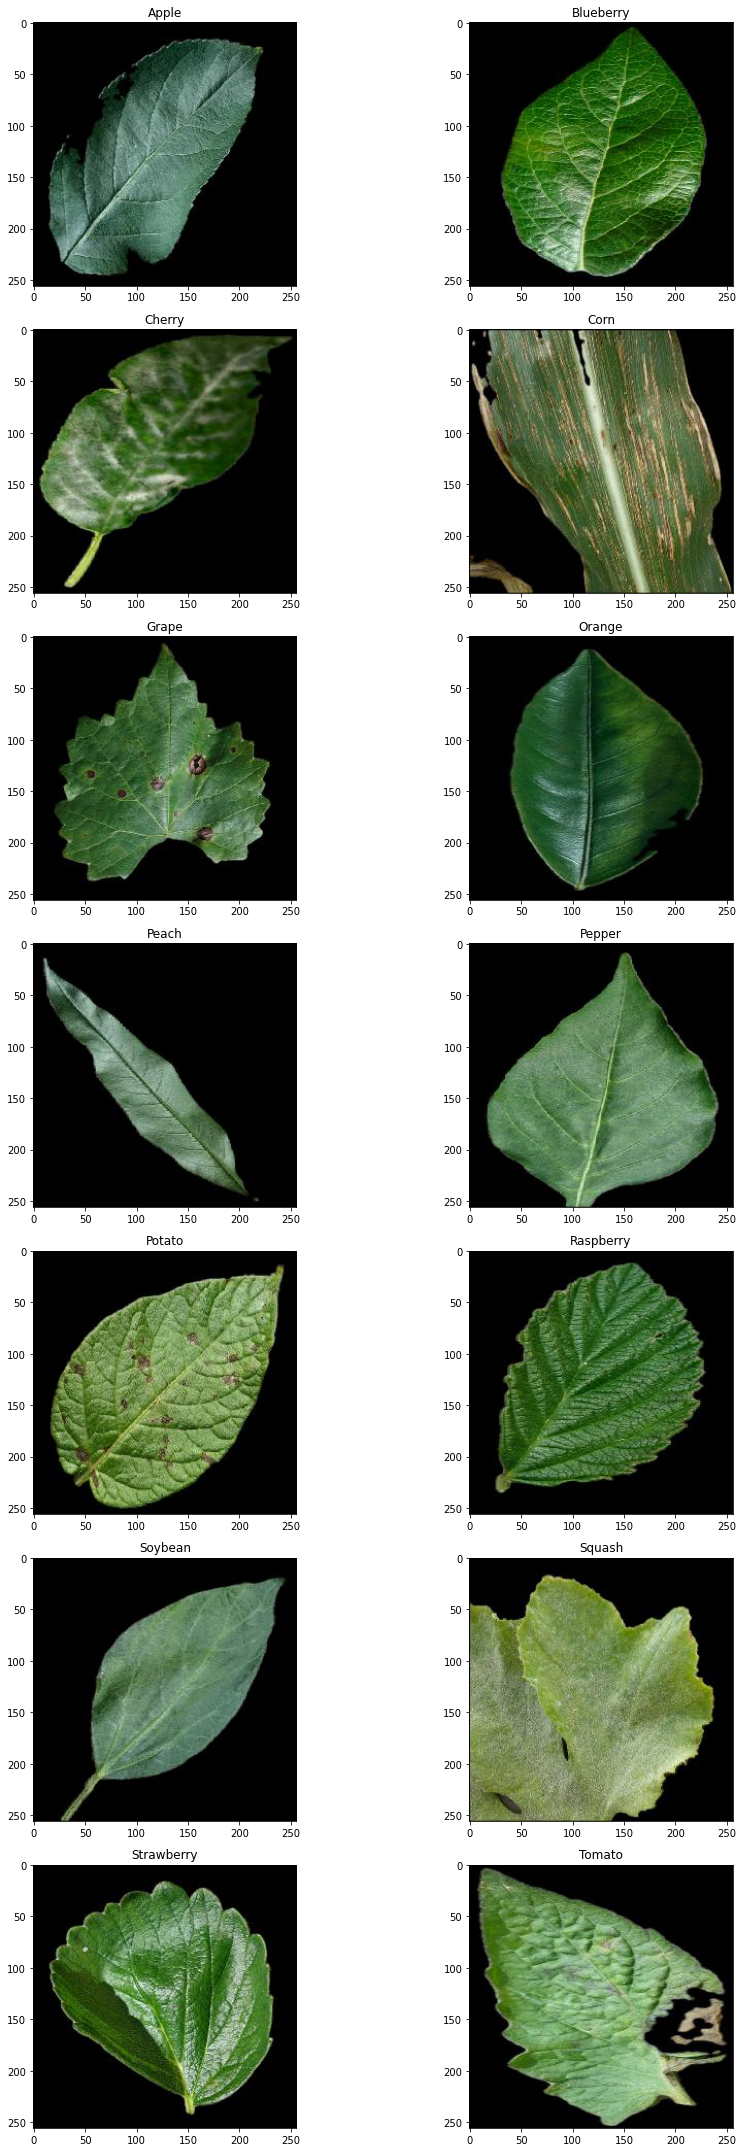

In [ ]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(training_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(training_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
%cd /


valid_data_gen = ImageDataGenerator()

aug_train_data_gen =  ImageDataGenerator(rotation_range=20,
                          height_shift_range=10,
                          width_shift_range=10,
                          zoom_range=0.3,
                          horizontal_flip=True,
                          vertical_flip=True,
                          fill_mode='nearest',
                          brightness_range=[0.8,1.2],
                          # rescale=1/255.
                          )

aug_train_gen =  aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                    target_size=(128,128),
                                                    color_mode = 'rgb',
                                                    class_mode='categorical',
                                                    batch_size = 16,
                                                    shuffle = True,
                                                    seed = seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                                    target_size=(128,128),
                                                    color_mode = 'rgb',
                                                    class_mode='categorical',
                                                    batch_size = 16,
                                                    shuffle = False,
                                                    seed = seed)


/
Found 11287 images belonging to 14 classes.
Found 1846 images belonging to 14 classes.


In [ ]:
#Building blocks

def conv_block(filters, n_conv, inputs):
    x = tfkl.Conv2D(filters, 3, activation="relu", padding="same")(inputs)
    for i in range(n_conv -1):
      x = tfkl.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = tfkl.BatchNormalization()(x)
    outputs = tfkl.MaxPool2D(pool_size = (2, 2))(x)
    return outputs


def dense_block(units, dropout_rate, inputs):
    x = tfkl.Dense(units, activation="relu")(inputs)
    x = tfkl.BatchNormalization()(x)
    outputs = tfkl.Dropout(dropout_rate)(x)

    return outputs

In [ ]:
# Model Building function
def build_model(input_shape):

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    x = conv_block(16, 2, input_layer)
    x = conv_block(32, 2, x)
    x = conv_block(64, 1, x)
    

    flattening_layer = tfkl.Flatten(name='Flatten')(x)
    flattening_layer = tfkl.Dropout(0.2, seed=seed)(flattening_layer)

    x = dense_block(128, 0.2, flattening_layer)

    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    optimizer = tf.keras.optimizers.Adam(0.0001)
    
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics='accuracy')

    return model


In [ ]:
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_12 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 32)        4640  

In [ ]:
# Add early stopping as callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

callbacks = []

callbacks.append(early_stopping)


## No Class Weights

In [ ]:
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks=callbacks
).history

Epoch 1/400
706/706 [==============================] - 65s 91ms/step - loss: 1.8695 - accuracy: 0.4345 - val_loss: 1.2889 - val_accuracy: 0.6046
Epoch 2/400
706/706 [==============================] - 64s 91ms/step - loss: 1.3362 - accuracy: 0.5827 - val_loss: 1.2039 - val_accuracy: 0.6100
Epoch 3/400
706/706 [==============================] - 64s 91ms/step - loss: 1.0896 - accuracy: 0.6552 - val_loss: 1.0750 - val_accuracy: 0.6609
Epoch 4/400
706/706 [==============================] - 64s 91ms/step - loss: 0.9286 - accuracy: 0.7053 - val_loss: 0.9666 - val_accuracy: 0.7004
Epoch 5/400
706/706 [==============================] - 64s 91ms/step - loss: 0.8299 - accuracy: 0.7374 - val_loss: 0.6831 - val_accuracy: 0.7811
Epoch 6/400
706/706 [==============================] - 63s 89ms/step - loss: 0.7261 - accuracy: 0.7676 - val_loss: 0.7732 - val_accuracy: 0.7606
Epoch 7/400
706/706 [==============================] - 63s 89ms/step - loss: 0.6716 - accuracy: 0.7874 - val_loss: 1.1065 - val_ac

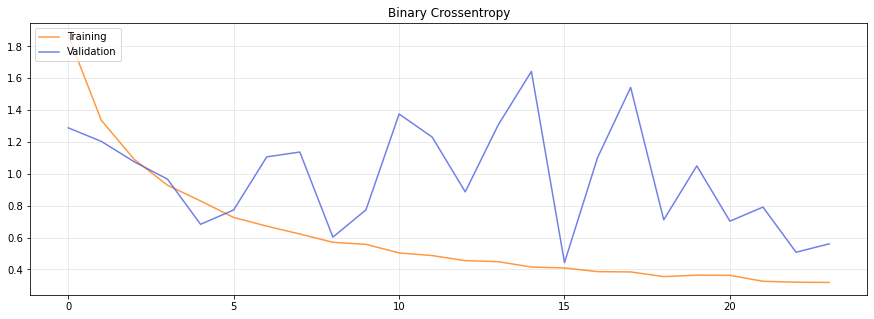

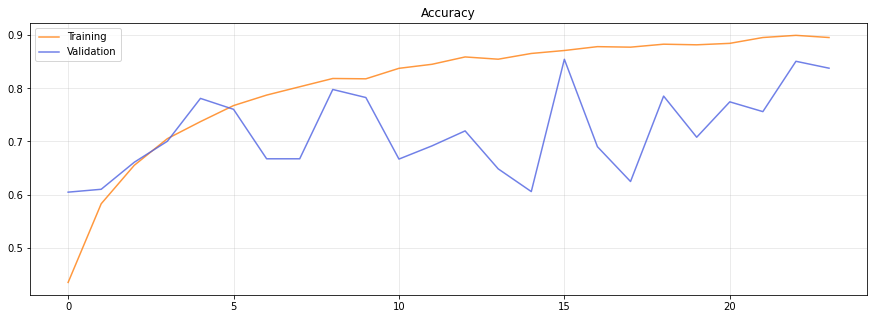

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(valid_gen, 5426)

y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(valid_gen.classes, y_pred)

print(cm)

print('Classification Report')

print(classification_report(valid_gen.classes, y_pred, target_names=labels))

Confusion Matrix
[[ 97   0   0   0   1   1   0   0   0   0   0   0   0   0]
 [  6  25   1   0   0   2   1   2   6   0   0   0   4   0]
 [ 13   0  37   0   1   1   2   1   2   0   2   0   0   0]
 [  2   0   0 115   0   0   1   0   1   0   0   2   0   0]
 [  1   0   0   0 221   0   0   0   0   0   0   1   2   0]
 [  5   0   1   0   0 245   0   0   2   0   1   0   0   0]
 [  8   0   0   0   0   0  88   0   0   0   0   0   1   1]
 [  7   0   0   0   1   3   1  61   0   2   1   0   0   1]
 [  1   0   0   0   0   0   0   2  53   3  10   0   1   2]
 [  0   0   0   0   1   0   0   0   0  26   0   0   0   0]
 [ 11   0   0   0   0   0   0   3   0   0 227   0   0   0]
 [  2   0   0   0   5   0   0   0   2   0   0  49   0   0]
 [  3   0   0   0   7   0   0   0   0   5   0   0  53   0]
 [ 23   0   0   1  23   6   2  20  20   9   8   5   2 281]]
Classification Report
              precision    recall  f1-score   support

       Apple       0.54      0.98      0.70        99
   Blueberry       1.00  

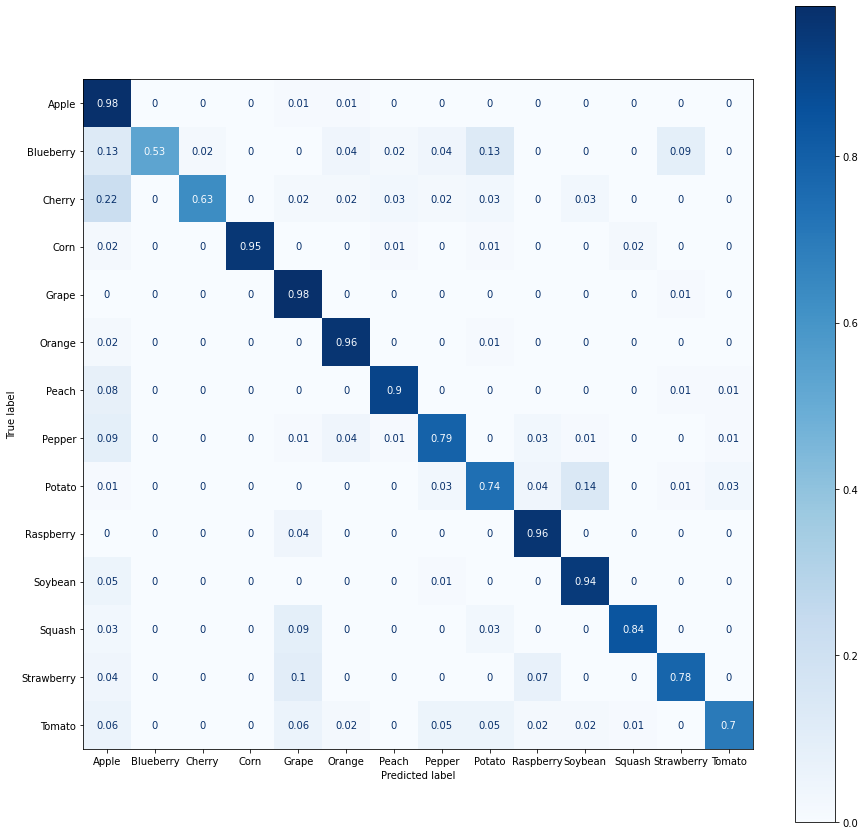

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay



cm1 = np.zeros(shape=(14,14))

for i in range(14):
  sum = np.sum(cm[i])
  for j in range(14):
    cm1[i][j] = round(cm[i][j]/sum,2)


disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

## Class Weights from Sklearn

In [ ]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(aug_train_gen.labels),
                                        y = aug_train_gen.labels                                                    
                                    )

print(class_weights)

minimum = 0
minimum = min(class_weights)

cw = {}
for i in range(14):
  cw[i] = class_weights[i]

print(cw)

[0.90687771 1.91955782 1.53857688 0.74305464 0.67184524 0.67184524
 0.91719486 1.17182309 1.25188554 3.40174804 0.67184524 1.56243079
 1.3325856  0.67184524]
{0: 0.9068777117146071, 1: 1.9195578231292516, 2: 1.538576881134133, 3: 0.7430546412113233, 4: 0.6718452380952381, 5: 0.6718452380952381, 6: 0.9171948642938405, 7: 1.1718230897009967, 8: 1.251885536823425, 9: 3.401748040988547, 10: 0.6718452380952381, 11: 1.5624307862679956, 12: 1.33258559622196, 13: 0.6718452380952381}


In [ ]:
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        4640  

In [ ]:
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks=callbacks,
    class_weight=cw
).history

Epoch 1/400
706/706 [==============================] - 62s 87ms/step - loss: 1.8775 - accuracy: 0.4145 - val_loss: 2.3089 - val_accuracy: 0.3575
Epoch 2/400
706/706 [==============================] - 62s 88ms/step - loss: 1.3306 - accuracy: 0.5637 - val_loss: 1.8242 - val_accuracy: 0.4816
Epoch 3/400
706/706 [==============================] - 62s 87ms/step - loss: 1.1264 - accuracy: 0.6266 - val_loss: 1.5682 - val_accuracy: 0.5282
Epoch 4/400
706/706 [==============================] - 62s 87ms/step - loss: 0.9683 - accuracy: 0.6798 - val_loss: 1.2942 - val_accuracy: 0.6165
Epoch 5/400
706/706 [==============================] - 62s 88ms/step - loss: 0.8781 - accuracy: 0.7094 - val_loss: 0.8240 - val_accuracy: 0.7346
Epoch 6/400
706/706 [==============================] - 63s 89ms/step - loss: 0.7816 - accuracy: 0.7412 - val_loss: 1.9641 - val_accuracy: 0.5049
Epoch 7/400
706/706 [==============================] - 62s 88ms/step - loss: 0.7560 - accuracy: 0.7478 - val_loss: 1.1463 - val_ac

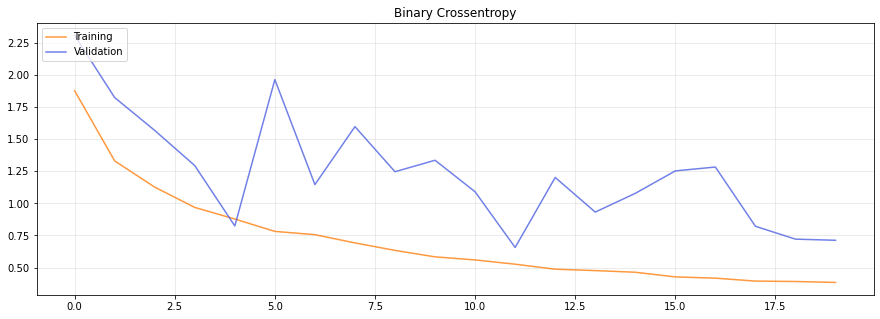

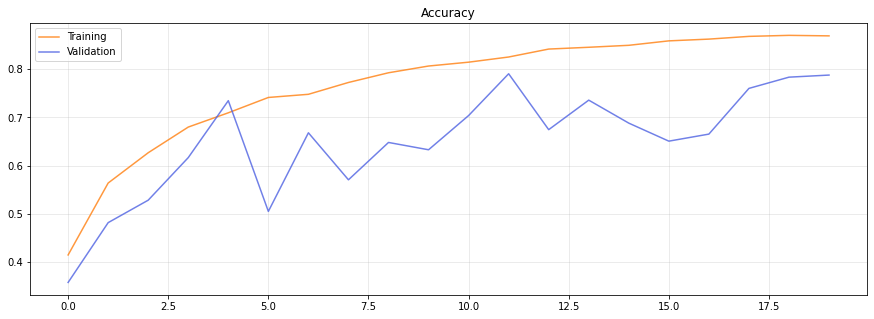

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## Class Weights from sklearn tuned

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(aug_train_gen.labels),
                                        y = aug_train_gen.labels                                                    
                                    )

print(class_weights)

minimum = 0
minimum = min(class_weights)

cw = {}
for i in range(14):
  # Here we add 1-minimum to get all weights "closer" and > 1 
  # The intuition was that weights with values < 1 were a way to much underestimated and having large difference between weights was not helpful
  # We came out with different solution and this is one of the best we found
  cw[i] = class_weights[i] + (1-minimum)

print(cw)

[0.90687771 1.91955782 1.53857688 0.74305464 0.67184524 0.67184524
 0.91719486 1.17182309 1.25188554 3.40174804 0.67184524 1.56243079
 1.3325856  0.67184524]
{0: 1.235032473619369, 1: 2.2477125850340136, 2: 1.8667316430388947, 3: 1.071209403116085, 4: 1.0, 5: 1.0, 6: 1.2453496261986023, 7: 1.4999778516057587, 8: 1.580040298728187, 9: 3.729902802893309, 10: 1.0, 11: 1.8905855481727576, 12: 1.6607403581267217, 13: 1.0}


In [ ]:
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_8 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        4640  

In [ ]:
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks=callbacks,
    class_weight=cw
).history

Epoch 1/400
706/706 [==============================] - 65s 91ms/step - loss: 2.5937 - accuracy: 0.4036 - val_loss: 1.2874 - val_accuracy: 0.5894
Epoch 2/400
706/706 [==============================] - 64s 91ms/step - loss: 1.9373 - accuracy: 0.5369 - val_loss: 1.2985 - val_accuracy: 0.6013
Epoch 3/400
706/706 [==============================] - 64s 91ms/step - loss: 1.5959 - accuracy: 0.6137 - val_loss: 1.9376 - val_accuracy: 0.4837
Epoch 4/400
706/706 [==============================] - 62s 88ms/step - loss: 1.3722 - accuracy: 0.6694 - val_loss: 0.9897 - val_accuracy: 0.7048
Epoch 5/400
706/706 [==============================] - 63s 89ms/step - loss: 1.2401 - accuracy: 0.7040 - val_loss: 1.2396 - val_accuracy: 0.6473
Epoch 6/400
706/706 [==============================] - 63s 89ms/step - loss: 1.1106 - accuracy: 0.7328 - val_loss: 1.4377 - val_accuracy: 0.6024
Epoch 7/400
706/706 [==============================] - 62s 88ms/step - loss: 1.0035 - accuracy: 0.7572 - val_loss: 1.2602 - val_ac

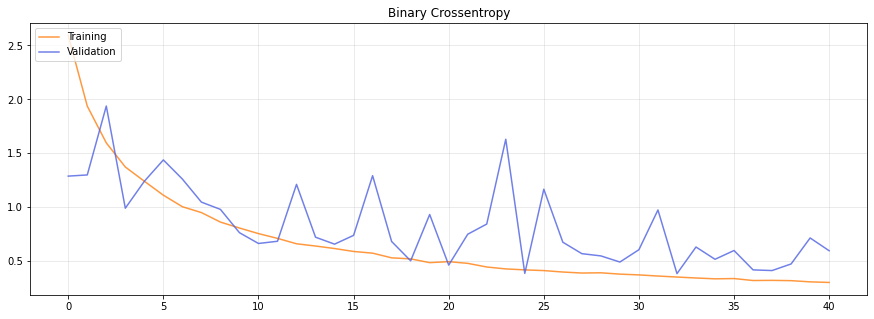

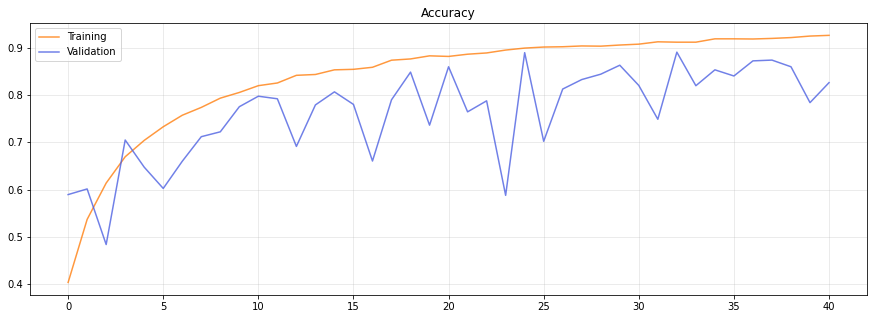

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(valid_gen, 5426)

y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(valid_gen.classes, y_pred)

print(cm)

print('Classification Report')

print(classification_report(valid_gen.classes, y_pred, target_names=labels))

Confusion Matrix
[[ 98   0   0   0   0   0   0   0   0   0   0   0   1   0]
 [  0  43   1   0   0   0   0   0   1   0   0   0   2   0]
 [  2   0  54   0   0   1   0   0   0   1   1   0   0   0]
 [  4   0   0 106   2   0   1   0   1   0   1   5   1   0]
 [  0   0   0   0 223   0   0   0   0   0   0   0   2   0]
 [  6   1   0   0   0 240   0   3   2   0   0   0   0   2]
 [  9   0   0   0   0   0  87   1   0   0   0   0   0   1]
 [  3   2   1   0   1   0   0  67   1   0   2   0   0   0]
 [  0   0   0   0   0   0   0   1  68   0   1   0   0   2]
 [  0   0   0   0   0   0   0   0   0  27   0   0   0   0]
 [  7   0   1   0   0   0   0   0   1   0 232   0   0   0]
 [  2   0   0   0   0   0   0   0   0   0   0  56   0   0]
 [  0   0   0   0   1   0   0   0   0   2   0   2  63   0]
 [ 25   0   0   0  16   5   2   2  23  34   7   3   3 280]]
Classification Report
              precision    recall  f1-score   support

       Apple       0.63      0.99      0.77        99
   Blueberry       0.93  

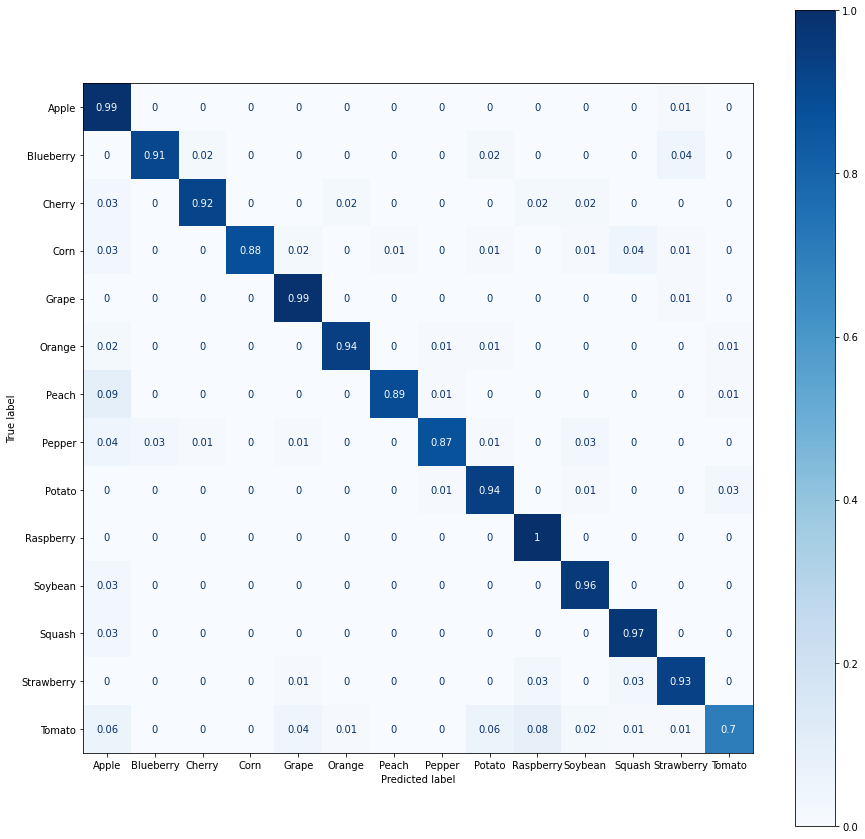

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay



cm1 = np.zeros(shape=(14,14))

for i in range(14):
  sum = np.sum(cm[i])
  for j in range(14):
    cm1[i][j] = round(cm[i][j]/sum,2)


disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

From confusion matrixes it is clear that class weights need to be considered as an option to achive good results in case of unbalanced classes
